In [25]:
import pandas as pd
import os
from utils.ml_utils import EmissionsPredictionPipeline
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [26]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
SCRIPT_DIR_PATH = os.getcwd()
ROOT_DIR_PATH = os.path.dirname(SCRIPT_DIR_PATH)
DATA_DIR_PATH = os.path.join(ROOT_DIR_PATH, "data")
MAPPING_DIR_PATH = os.path.join(DATA_DIR_PATH, "mapping")
PREDICTORS_DIR_PATH = os.path.join(DATA_DIR_PATH, "predictors")
SSP_DIR_PATH = os.path.join(DATA_DIR_PATH, "ssp")
SIMULATION_DIR_PATH = os.path.join(SSP_DIR_PATH, "sisepuede_run_2025-01-14T17;04;06.975301_output_database")
TRAINING_DIR_PATH = os.path.join(DATA_DIR_PATH, "training")

In [28]:
TRAINING_DATA_PATH = os.path.join(TRAINING_DIR_PATH, "training_data.csv")
training_df = pd.read_csv(TRAINING_DATA_PATH)
training_df = training_df.drop(columns=["primary_id", "future_id"])
training_df.head()

,1,2,3,4,5,6,7,8,9,10,...,1472,1473,1474,1475,1476,1477,1478,1480,1481,total_emissions_last_five_years
0,0.980563,0.622679,0.140236,0.802093,0.809239,0.204801,0.524637,0.630477,0.832595,0.820676,...,0.194148,0.302870,0.936163,0.489698,0.355706,0.973953,0.163635,0.502731,0.215820,670.507643
1,0.735548,0.301887,0.427054,0.403958,0.065751,0.112043,0.129692,0.464848,0.471658,0.077887,...,0.391113,0.627638,0.037490,0.116765,0.956556,0.605262,0.993768,0.606901,0.649376,604.450538
2,0.483432,0.687238,0.788480,0.682344,0.550297,0.173999,0.258569,0.959298,0.102355,0.432940,...,0.085676,0.160749,0.503487,0.717740,0.322667,0.269358,0.440815,0.146352,0.294294,475.708631
3,0.978340,0.251633,0.057635,0.432074,0.356407,0.050955,0.819088,0.708194,0.664282,0.536167,...,0.671211,0.635634,0.696036,0.291799,0.842492,0.965798,0.610868,0.941222,0.623498,758.004335
4,0.096028,0.866167,0.248441,0.529266,0.495278,0.261648,0.640538,0.341921,0.513636,0.236388,...,0.156381,0.243530,0.098165,0.546683,0.467180,0.449347,0.442861,0.823770,0.297142,600.771431


## EDA

In [29]:
training_df["total_emissions_last_five_years"].describe()

count    1.000000e+03
mean     7.690960e+05
std      1.071674e+07
min      3.616263e+02
25%      6.362033e+02
50%      7.210529e+02
75%      7.955229e+02
max      2.268719e+08
Name: total_emissions_last_five_years, dtype: float64

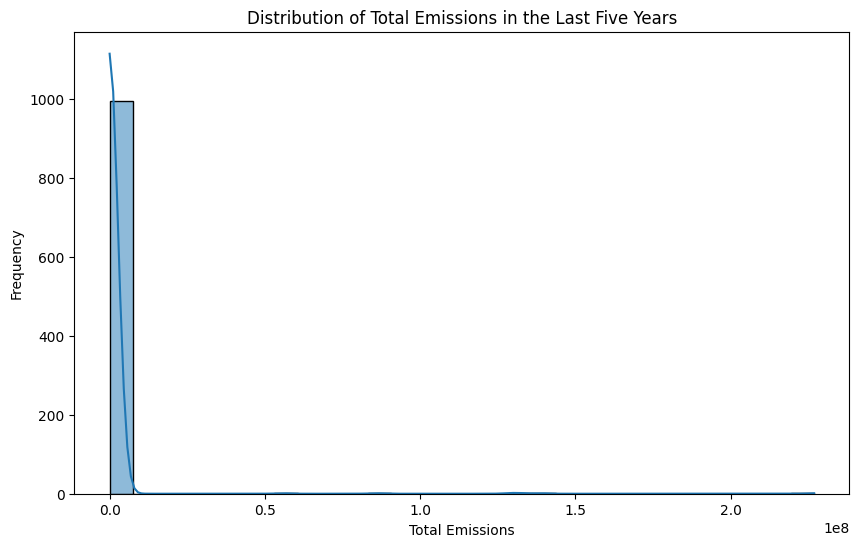

In [30]:
def plot_emissions_histogram(df, column="total_emissions_last_five_years", bins=30, kde=True, title="Distribution of Total Emissions in the Last Five Years"):
    plt.figure(figsize=(10, 6))
    sns.histplot(df[column], bins=bins, kde=kde)
    plt.title(title)
    plt.xlabel("Total Emissions")
    plt.ylabel("Frequency")
    plt.show()

plot_emissions_histogram(training_df)


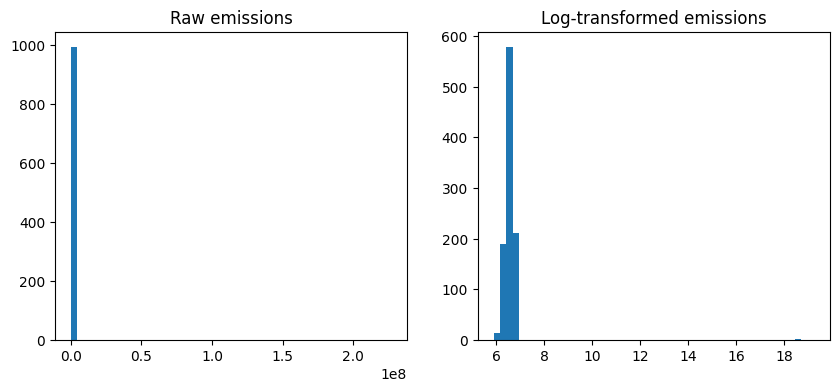

In [31]:
y = training_df['total_emissions_last_five_years']
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].hist(y, bins=50)
ax[0].set_title("Raw emissions")
ax[1].hist(np.log1p(y), bins=50)
ax[1].set_title("Log-transformed emissions")
plt.show()


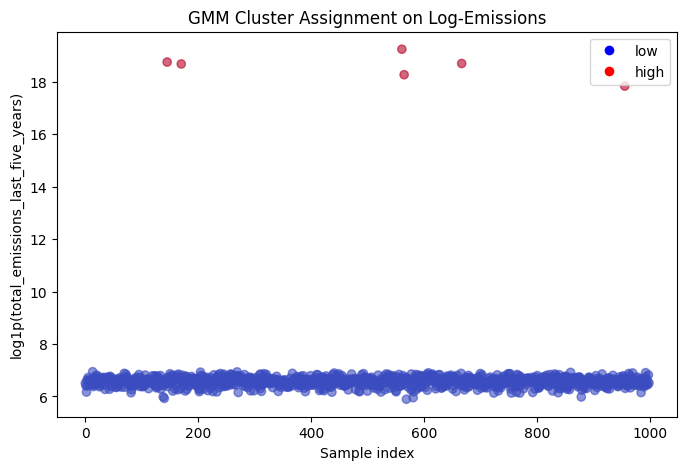

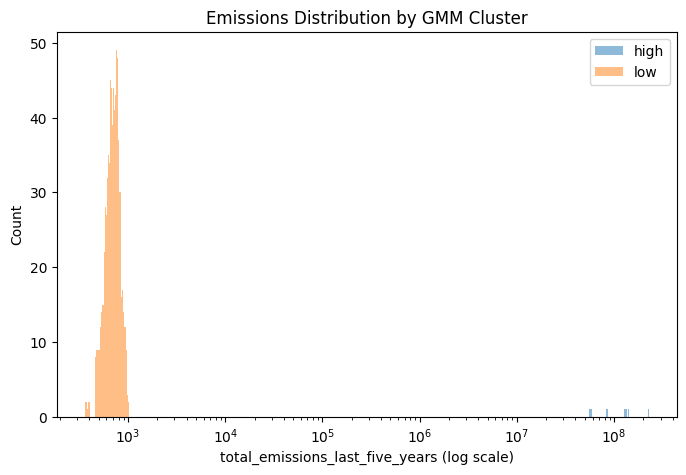

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

# 1. Fit GMM on log1p(target)
y = training_df['total_emissions_last_five_years']
log_y = np.log1p(y).values.reshape(-1,1)

gm = GaussianMixture(n_components=2, random_state=0)
labels = gm.fit_predict(log_y)

# 2. Map labels to “low” vs “high” based on cluster means
means = gm.means_.flatten()
low_lab, high_lab = np.argsort(means)
label_map = {low_lab: 'low', high_lab: 'high'}

training_df['cluster'] = labels
training_df['cluster_name'] = training_df['cluster'].map(label_map)

# 3. Scatter plot of log-emissions colored by cluster
plt.figure(figsize=(8,5))
plt.scatter(training_df.index, log_y.flatten(),
            c=training_df['cluster'], cmap='coolwarm', alpha=0.6)
plt.xlabel('Sample index')
plt.ylabel('log1p(total_emissions_last_five_years)')
plt.title('GMM Cluster Assignment on Log-Emissions')
plt.legend(handles=[
    plt.Line2D([], [], marker='o', color='w', label='low',  markerfacecolor='blue', markersize=8),
    plt.Line2D([], [], marker='o', color='w', label='high', markerfacecolor='red',  markersize=8)
])
plt.show()

# 4. (Optional) Overlaid histograms on original scale
plt.figure(figsize=(8,5))
for name, grp in training_df.groupby('cluster_name'):
    plt.hist(grp['total_emissions_last_five_years'],
             bins=50, alpha=0.5, label=name)
plt.xscale('log')
plt.xlabel('total_emissions_last_five_years (log scale)')
plt.ylabel('Count')
plt.title('Emissions Distribution by GMM Cluster')
plt.legend()
plt.show()


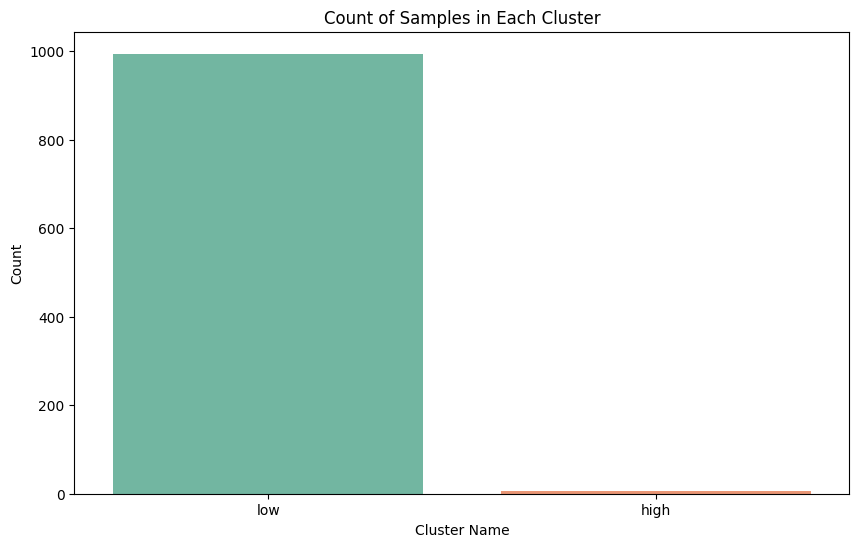

In [33]:
# plot bar graph of the two categories of cluster name
plt.figure(figsize=(10, 6))
sns.countplot(data=training_df, x='cluster_name', palette='Set2', hue="cluster_name")
plt.title("Count of Samples in Each Cluster")
plt.xlabel("Cluster Name")
plt.ylabel("Count")
plt.show()

## Data Cleaning

In [34]:
training_df.head()

,1,2,3,4,5,6,7,8,9,10,...,1474,1475,1476,1477,1478,1480,1481,total_emissions_last_five_years,cluster,cluster_name
0,0.980563,0.622679,0.140236,0.802093,0.809239,0.204801,0.524637,0.630477,0.832595,0.820676,...,0.936163,0.489698,0.355706,0.973953,0.163635,0.502731,0.215820,670.507643,0,low
1,0.735548,0.301887,0.427054,0.403958,0.065751,0.112043,0.129692,0.464848,0.471658,0.077887,...,0.037490,0.116765,0.956556,0.605262,0.993768,0.606901,0.649376,604.450538,0,low
2,0.483432,0.687238,0.788480,0.682344,0.550297,0.173999,0.258569,0.959298,0.102355,0.432940,...,0.503487,0.717740,0.322667,0.269358,0.440815,0.146352,0.294294,475.708631,0,low
3,0.978340,0.251633,0.057635,0.432074,0.356407,0.050955,0.819088,0.708194,0.664282,0.536167,...,0.696036,0.291799,0.842492,0.965798,0.610868,0.941222,0.623498,758.004335,0,low
4,0.096028,0.866167,0.248441,0.529266,0.495278,0.261648,0.640538,0.341921,0.513636,0.236388,...,0.098165,0.546683,0.467180,0.449347,0.442861,0.823770,0.297142,600.771431,0,low


In [35]:
# remove cluster == 1
training_df = training_df[training_df['cluster'] == 0]
training_df = training_df.drop(columns=['cluster', 'cluster_name'])
training_df.head()

,1,2,3,4,5,6,7,8,9,10,...,1472,1473,1474,1475,1476,1477,1478,1480,1481,total_emissions_last_five_years
0,0.980563,0.622679,0.140236,0.802093,0.809239,0.204801,0.524637,0.630477,0.832595,0.820676,...,0.194148,0.302870,0.936163,0.489698,0.355706,0.973953,0.163635,0.502731,0.215820,670.507643
1,0.735548,0.301887,0.427054,0.403958,0.065751,0.112043,0.129692,0.464848,0.471658,0.077887,...,0.391113,0.627638,0.037490,0.116765,0.956556,0.605262,0.993768,0.606901,0.649376,604.450538
2,0.483432,0.687238,0.788480,0.682344,0.550297,0.173999,0.258569,0.959298,0.102355,0.432940,...,0.085676,0.160749,0.503487,0.717740,0.322667,0.269358,0.440815,0.146352,0.294294,475.708631
3,0.978340,0.251633,0.057635,0.432074,0.356407,0.050955,0.819088,0.708194,0.664282,0.536167,...,0.671211,0.635634,0.696036,0.291799,0.842492,0.965798,0.610868,0.941222,0.623498,758.004335
4,0.096028,0.866167,0.248441,0.529266,0.495278,0.261648,0.640538,0.341921,0.513636,0.236388,...,0.156381,0.243530,0.098165,0.546683,0.467180,0.449347,0.442861,0.823770,0.297142,600.771431


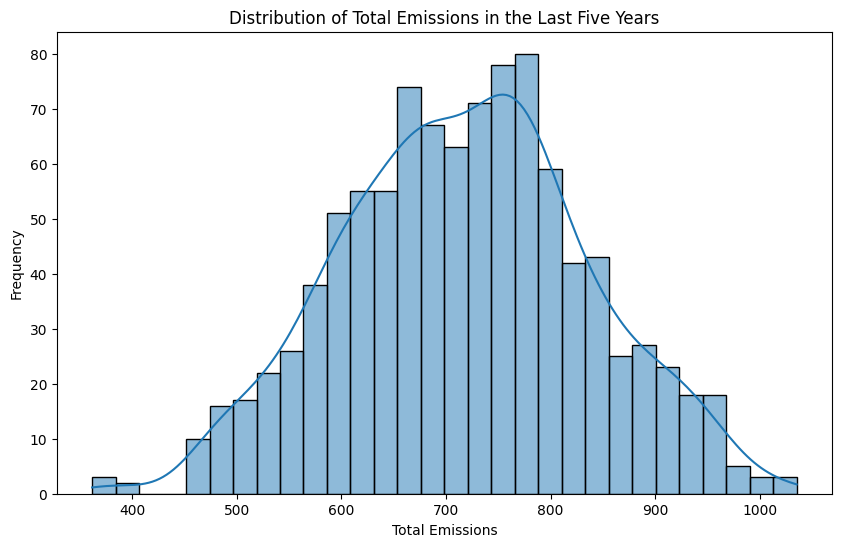

In [36]:
#plot histogram of total_emissions
plt.figure(figsize=(10, 6))
sns.histplot(training_df["total_emissions_last_five_years"], bins=30, kde=True)
plt.title("Distribution of Total Emissions in the Last Five Years")
plt.xlabel("Total Emissions")
plt.ylabel("Frequency")
plt.show()

In [37]:
training_df["total_emissions_last_five_years"].describe()

count     994.000000
mean      717.252770
std       117.737676
min       361.626320
25%       635.400195
50%       719.714422
75%       794.299010
max      1035.283867
Name: total_emissions_last_five_years, dtype: float64

## EDA Again

In [38]:
#TODO: OPEN THE CLASS HERE
epp = EmissionsPredictionPipeline(training_df, target="total_emissions_last_five_years", test_size=0.2, random_state=42,)

In [39]:
epp.df

,1,2,3,4,5,6,7,8,9,10,...,1472,1473,1474,1475,1476,1477,1478,1480,1481,total_emissions_last_five_years
0,0.980563,0.622679,0.140236,0.802093,0.809239,0.204801,0.524637,0.630477,0.832595,0.820676,...,0.194148,0.302870,0.936163,0.489698,0.355706,0.973953,0.163635,0.502731,0.215820,670.507643
1,0.735548,0.301887,0.427054,0.403958,0.065751,0.112043,0.129692,0.464848,0.471658,0.077887,...,0.391113,0.627638,0.037490,0.116765,0.956556,0.605262,0.993768,0.606901,0.649376,604.450538
2,0.483432,0.687238,0.788480,0.682344,0.550297,0.173999,0.258569,0.959298,0.102355,0.432940,...,0.085676,0.160749,0.503487,0.717740,0.322667,0.269358,0.440815,0.146352,0.294294,475.708631
3,0.978340,0.251633,0.057635,0.432074,0.356407,0.050955,0.819088,0.708194,0.664282,0.536167,...,0.671211,0.635634,0.696036,0.291799,0.842492,0.965798,0.610868,0.941222,0.623498,758.004335
4,0.096028,0.866167,0.248441,0.529266,0.495278,0.261648,0.640538,0.341921,0.513636,0.236388,...,0.156381,0.243530,0.098165,0.546683,0.467180,0.449347,0.442861,0.823770,0.297142,600.771431
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.686931,0.293175,0.530016,0.537532,0.547453,0.592252,0.145215,0.595690,0.226719,0.555106,...,0.166374,0.492576,0.852423,0.576864,0.581870,0.729968,0.670905,0.526597,0.538860,623.338641
996,0.652014,0.614792,0.722367,0.728350,0.258821,0.451143,0.933635,0.699838,0.318238,0.118908,...,0.081739,0.427041,0.841771,0.700368,0.034557,0.110096,0.358843,0.228176,0.567834,747.358673
997,0.194568,0.471448,0.336939,0.843803,0.291440,0.503017,0.002373,0.607189,0.445903,0.462059,...,0.483941,0.270658,0.453539,0.533885,0.448723,0.985748,0.874981,0.341813,0.518431,634.154137
998,0.298093,0.985266,0.876711,0.357384,0.324181,0.318030,0.521157,0.057600,0.803029,0.038362,...,0.826473,0.188016,0.836447,0.053303,0.036249,0.291268,0.829999,0.494574,0.087424,915.717778


In [19]:
# Correlation with target
corr = training_df.corr()[epp.target].sort_values(ascending=False)
print("Top 10 Correlated Features:\n", corr.head(11))


Top 10 Correlated Features:
 total_emissions_last_five_years    1.000000
44                                 0.062801
262                                0.062671
27                                 0.055023
1384                               0.054130
24                                 0.051682
1464                               0.045807
22                                 0.044632
1466                               0.043101
2                                  0.042732
31                                 0.041644
Name: total_emissions_last_five_years, dtype: float64


In [20]:
epp.df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 994 entries, 0 to 999
Data columns (total 81 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   1                                994 non-null    float64
 1   2                                994 non-null    float64
 2   3                                994 non-null    float64
 3   4                                994 non-null    float64
 4   5                                994 non-null    float64
 5   6                                994 non-null    float64
 6   7                                994 non-null    float64
 7   8                                994 non-null    float64
 8   9                                994 non-null    float64
 9   10                               994 non-null    float64
 10  12                               994 non-null    float64
 11  13                               994 non-null    float64
 12  14                         

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best hyperparameters: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 0.5, 'max_depth': 30}
MAE: 86.95161130190043
RMSE: 105.60286897114695
R^2 Score: 0.10543306492527649


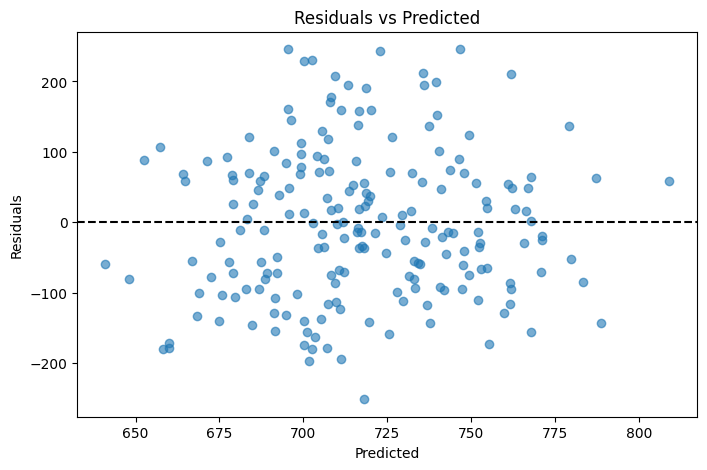

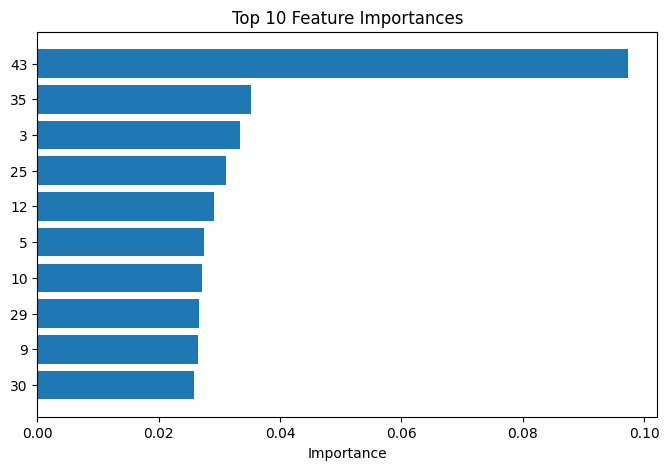

In [24]:
epp.run(True, False, True)

## ML